# Problem statement

Currently the interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

You can check all details about the competition from following link :
https://www.kaggle.com/c/msk-redefining-cancer-treatment

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re, time, warnings, math, string
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from scipy.sparse import hstack
from collections import Counter, defaultdict
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings("ignore")

## Pre-processing

In [2]:
data_variants = pd.read_csv('./data/training/training_variants')
data_text = pd.read_csv("./data/training/training_text", sep="\|\|", names=["ID", "TEXT"], skiprows=1)
df = pd.merge(data_variants, data_text,on='ID', how='left')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>

In [3]:
stop_words = stopwords.words('english')
def text_processing(total_text):
    if type(total_text) is not int:
        # replacing special char with space, multiple spaces with single space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        total_text = re.sub('\s+',' ', str(total_text))
        total_text = total_text.lower()
        
        # tokens = nltk.tokenize.word_tokenize(total_text.lower())
        # tokens = [t for t in tokens if len(t) > 2] 
        # tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] 
        # tokens = [t for t in tokens if t not in stopwords.words('english')] 
        # tokens = [t for t in tokens if t not in string.punctuation]
        
        string = [word for word in total_text.split() if word not in stop_words]
        string = ' '.join(string)
        return string

In [4]:
df['TEXT'] = df['TEXT'].apply(text_processing)
df.loc[df['TEXT'].isnull(), 'TEXT'] = df['Gene'] + ' ' + df['Variation']
df['Gene'] = df['Gene'].str.replace('\s+', '_')
df['Variation'] = df['Variation'].str.replace('\s+', '_')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [5]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

In [6]:
# stratified train_test_split
y_true = df['Class'].values
X_train, test_df, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [7]:
print('Train Data:', train_df.shape)
print('Test Data:', test_df.shape)
print('Cross Validation Data:', cv_df.shape)

Train Data: (2124, 5)
Test Data: (665, 5)
Cross Validation Data: (532, 5)


In [8]:
(train_df['Class'].value_counts().sort_index() / train_df.shape[0]).round(4) * 100

1    17.09
2    13.61
3     2.68
4    20.67
5     7.30
6     8.29
7    28.67
8     0.56
9     1.13
Name: Class, dtype: float64

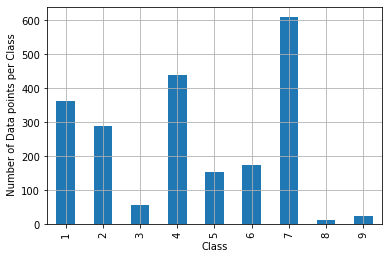

In [9]:
train_df['Class'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.grid()

## Data Preparation

### Gene Column

In [10]:
gene_value = train_df['Gene'].value_counts()
gene_value

BRCA1    171
TP53     109
EGFR      85
BRCA2     81
PTEN      76
        ... 
CTLA4      1
JUN        1
SHOC2      1
RAD21      1
LATS2      1
Name: Gene, Length: 232, dtype: int64

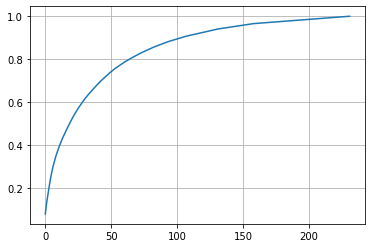

In [11]:
cum_sum = np.cumsum(gene_value.values / sum(gene_value.values))
plt.plot(cum_sum, label='Cumulative distribution of Genes')
plt.grid()

2 techniques to convert these categorical variable to appropirate format

<ol><li>
     ***One-hot encoding*** (Binary with more columns)</li>
    <li> ***Response Encoding*** (Mean imputation) </li>
</ol>

In [12]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

print(train_gene_feature_onehotCoding.shape)

(2124, 232)


In [13]:
# columns name for one hot encoder
gene_vectorizer.get_feature_names()[90:98]

['foxp1', 'gata3', 'gna11', 'gnaq', 'gnas', 'h3f3a', 'hnf1a', 'hras']

In [14]:
def get_gv_feature(alpha=1, feature='Gene', df_temp=train_df):
    '''Laplace smoothing
    ==========================================
    Consider all unique values & the no. of occurances of given feature dataframe
    Build a vector (1*9)
    1st element = (no. of times it occured in class1 + 10 * alpha / 
                        no. of time it occurred in total data + 90 * alpha)
    gv_dict is a look up table, for every gene it store a (1 * 9) representation of it
    If a value of feature(from test data) not in train data:
    add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9]
    else add the vector that was stored in 'gv_dict'
    '''
    
    # create dictionaries using train_df
    value_count = train_df[feature].value_counts()
    # count for Gene(index) and Class (columns)
    foo = train_df.groupby([feature, 'Class']).count()['ID'].unstack().fillna(0)
    # value count for each Gene
    bar = train_df[feature].value_counts().reindex(foo.index)
    foo = (foo + alpha * 10).divide(bar + 90 * alpha, axis=0)
    gv_dict = foo.T.to_dict('list')
    
    # add [1/9] * 9 if no value
    # print([x for x in df_temp[feature] if x not in gv_dict.keys()])
    gv_fea = [gv_dict.get(x, [1/9] * 9) for x in df_temp[feature]]
    
    return np.array(gv_fea)

In [15]:
# response-coding of the Gene feature
alpha = 1
train_gene_feature_responseCoding = get_gv_feature(alpha, "Gene", train_df)
test_gene_feature_responseCoding = get_gv_feature(alpha, "Gene", test_df)
cv_gene_feature_responseCoding = get_gv_feature(alpha, "Gene", cv_df)

print(train_gene_feature_responseCoding.shape)

(2124, 9)


In [16]:
# Use sgd classifier to evaluate the effectiveness of Gene column to predict my 9 classes
# Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array = []
alpha = [10 ** x for x in range(-5, 1)]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    print(f'Alpha: {i}, \tLog Loss: {log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)}')

Alpha: 1e-05, 	Log Loss: 1.223967996539321
Alpha: 0.0001, 	Log Loss: 1.207646952225036
Alpha: 0.001, 	Log Loss: 1.2573538451893496
Alpha: 0.01, 	Log Loss: 1.370063621357073
Alpha: 0.1, 	Log Loss: 1.4530179218145183
Alpha: 1, 	Log Loss: 1.4792952133528552


In [17]:
clf = SGDClassifier(alpha=0.0001, penalty='l2', loss='log')
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('Train Log Loss', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('CV Log Loss', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('Test Log Loss', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Train Log Loss 0.9776644273404804
CV Log Loss 1.2065297496638867
Test Log Loss 1.1951959289951752


In [18]:
# check how many values are overlapping between train, test or between CV and train

test_coverage = len([x for x in test_df['Gene'] if x in train_df['Gene'].unique()])
print('Test Coverage', round(test_coverage / test_df.shape[0], 5) * 100, '%')

cv_coverage = len([x for x in cv_df['Gene'] if x in train_df['Gene'].unique()])
print('CV Coverage', round(cv_coverage / cv_df.shape[0], 5) * 100, '%')

Test Coverage 97.143 %
CV Coverage 95.113 %


### Variation column

In [19]:
variations_value = train_df['Variation'].value_counts()
variations_value

Truncating_Mutations    54
Deletion                47
Amplification           42
Fusions                 20
Q61H                     3
                        ..
A1752P                   1
D837N                    1
D594G                    1
I111N                    1
D140G                    1
Name: Variation, Length: 1935, dtype: int64

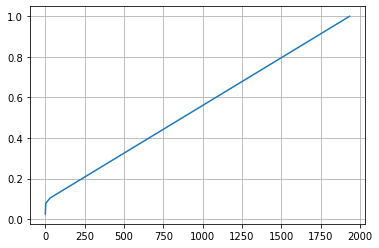

In [20]:
cum_sum = np.cumsum(variations_value.values / sum(variations_value.values))
plt.plot(cum_sum, label='Cumulative distribution of Genes')
plt.grid()

In [21]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

print(train_variation_feature_onehotCoding.shape)

(2124, 1960)


In [22]:
# response coding
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print(train_variation_feature_responseCoding.shape)

(2124, 9)


In [23]:
# Use sgd classifier to evaluate the effectiveness of Gene column to predict my 9 classes
# Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array = []
alpha = [10 ** x for x in range(-5, 1)]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    print(f'Alpha: {i}, \tLog Loss: {log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)}')

Alpha: 1e-05, 	Log Loss: 1.706588495612754
Alpha: 0.0001, 	Log Loss: 1.692578043821704
Alpha: 0.001, 	Log Loss: 1.693093504997069
Alpha: 0.01, 	Log Loss: 1.6974264323995263
Alpha: 0.1, 	Log Loss: 1.7050290311127565
Alpha: 1, 	Log Loss: 1.7054813117723882


In [24]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log')
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('Train Log Loss', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('CV Log Loss', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('Test Log Loss', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Train Log Loss 1.083463402153111
CV Log Loss 1.6930579678473912
Test Log Loss 1.6908735592586865


In [25]:
# check how many values are overlapping between train, test or between CV and train
test_coverage = len([x for x in test_df['Variation'] if x in train_df['Variation'].unique()])
print('Test Coverage', round(test_coverage / test_df.shape[0], 5) * 100, '%')

cv_coverage = len([x for x in cv_df['Variation'] if x in train_df['Variation'].unique()])
print('CV Coverage', round(cv_coverage / cv_df.shape[0], 5) * 100, '%')

Test Coverage 9.925 %
CV Coverage 11.842 %


### Text column

In [26]:
def extract_dictionary_paddle(cls_text):
    '''Record count of occurences for each word'''
    word_dict = defaultdict(int)
    for words in cls_text.str.split():
        for word in words:
            word_dict[word] +=1
    return word_dict

def get_text_responsecoding(text):
    '''Computation of response encoding'''
    prob_lis = np.array([0] * 9)
    for word in text.split():
        temp_lis = np.array([math.log((dict_list[i].get(word, 0) + 10 ) / 
                                      (total_dict.get(word, 0) + 90)) 
                             for i in dict_list.keys()])
        prob_lis = prob_lis + temp_lis

    return np.exp(prob_lis / len(text.split()))

In [27]:
# CountVectorizer with all the words that occured minimum 3 times in data
# count the number of occurence of each words for each row
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

# use anther way TF-IDF
# tf_vectorizer = TfidfVectorizer()
# train_text_feature_onehotCoding = tf_vectorizer.fit_transform(train_df['TEXT'])

In [28]:
train_text_features = text_vectorizer.get_feature_names()

# sum every row and returns (1 * number of features) vector
# count the total number of occurences in whole documents
train_text_fea_counts = np.array(train_text_feature_onehotCoding.sum(axis=0)).ravel()

# zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))
print(len(train_text_features))

# list of words + occurences for each class
foo = train_df.groupby('Class')['TEXT'].apply(extract_dictionary_paddle).dropna()
dict_list = {index: foo.xs(index).to_dict() for index in set(x[0] for x in foo.index)}
total_dict = extract_dictionary_paddle(train_df['TEXT'])

# confuse array from total_dict and dict_list
confuse_array = []
for i in train_text_features:
    lis = [(dict_list[j].get(i, 0) + 10 ) / (total_dict[i] + 90) for j in dict_list.keys()]
    confuse_array.append(lis)
confuse_array = np.array(confuse_array)

52430


In [29]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({1.7320508075688776: 6002, 2.0: 3439, 2.23606797749979: 2003, 2.6457513110645907: 1825, 2.4494897427831783: 1456, 2.82842712474619: 1305, 3.0: 1255, 3.1622776601683795: 659, 1.6329931618554523: 629, 3.4641016151377557: 583, 3.3166247903554003: 548, 3.741657386773941: 482, 1.7320508075688772: 418, 3.8729833462074157: 367, 1.889822365046136: 365, 3.60555127546399: 299, 1.6666666666666665: 299, 2.1213203435596424: 283, 1.5075567228888183: 236, 4.47213595499958: 226, 4.358898943540673: 226, 4.123105625617661: 210, 4.0: 208, 2.5298221281347035: 190, 6.164414002968979: 173, 1.8973665961010275: 170, 2.333333333333333: 167, 6.855654600401047: 165, 6.000000000000001: 143, 2.886751345948129: 128, 2.713602101199873: 121, 1.7320508075688774: 120, 1.6059101370939322: 118, 4.690415759823428: 113, 2.138089935299395: 112, 4.242640687119286: 111, 2.8284271247461907: 108, 1.8898223650461359: 108, 5.000000000000001: 104, 3.0508510792387606: 101, 2.182820625326997: 96, 4.795831523312721: 92, 1.414

In [30]:
# response coding of text features
train_text_feature_responseCoding  = np.array([x for x in train_df['TEXT'].apply(get_text_responsecoding)])
test_text_feature_responseCoding  = np.array([x for x in test_df['TEXT'].apply(get_text_responsecoding)])
cv_text_feature_responseCoding  = np.array([x for x in cv_df['TEXT'].apply(get_text_responsecoding)])

# convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T / train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T / test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T / cv_text_feature_responseCoding.sum(axis=1)).T

In [31]:
# Use sgd classifier to evaluate the effectiveness of Gene column to predict my 9 classes
# Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array = []
alpha = [10 ** x for x in range(-5, 1)]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    print(f'Alpha: {i}, \tLog Loss: {log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)}')

Alpha: 1e-05, 	Log Loss: 1.308628315384803
Alpha: 0.0001, 	Log Loss: 1.2061150885406022
Alpha: 0.001, 	Log Loss: 1.1751090449140307
Alpha: 0.01, 	Log Loss: 1.2350592516738974
Alpha: 0.1, 	Log Loss: 1.4826290421358392
Alpha: 1, 	Log Loss: 1.6474847944469175


In [32]:
clf = SGDClassifier(alpha=0.0001, penalty='l2', loss='log')
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('Train Log Loss', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('CV Log Loss', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('Test Log Loss', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Train Log Loss 0.6546330579485468
CV Log Loss 1.1938667329970511
Test Log Loss 1.2116123999768345


## Combining all 3 features together

In [33]:
# combine one hot encoding of gene and variation
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

# combine one hot encoding of gene, variation and text
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

# combine response encoding of gene and variation
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding, cv_variation_feature_responseCoding))

# combine response encoding of text, gene and variation
train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

# y true
train_y = train_df['Class'].values
test_y = test_df['Class'].values
cv_y = cv_df['Class'].values

In [34]:
print(train_x_onehotCoding.shape)
print(train_x_responseCoding.shape)

(2124, 54622)
(2124, 27)


# Set Up

## Utiity Functions

In [35]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    '''Log Loss Calculation'''
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def plot_confusion_matrix(test_y, predict_y, metric=False):
    '''Plot Confusion Matrix and Heatmap'''
    
    C = confusion_matrix(test_y, predict_y)
    A = (C.T / C.sum(axis=1)).T
    B = C / C.sum(axis=0) 
    labels = np.arange(1, 10)
    
    print("-" * 20, "Confusion matrix", "-" * 20)
    plt.figure(figsize=(15, 5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    
    if metric:
        print("-" * 20, "Precision matrix (Columm Sum = 1)", "-" * 20)
        plt.figure(figsize=(15, 5))
        sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')

        print("-" * 20, "Recall matrix (Row sum = 1)", "-" * 20)
        plt.figure(figsize=(15, 5))
        sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
    
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    '''Report Performance'''
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :", log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("% of Incorrect points :", np.count_nonzero((pred_y - test_y)) / test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

## Building a Random model

In [36]:
cv_random_y = np.random.rand(cv_df.shape[0], 9)
cv_random_y = cv_random_y / cv_random_y.sum(axis=1).reshape(cv_df.shape[0], 1)
print("Log loss for CV (Random Model)", log_loss(y_cv, cv_random_y, eps=1e-15))

test_random_y = np.random.rand(test_df.shape[0], 9)
test_random_y = test_random_y / test_random_y.sum(axis=1).reshape(test_df.shape[0], 1)
print("Log loss for Test (Random Model)", log_loss(y_test, test_random_y, eps=1e-15))

# convert 0 - 8 into 1 - 9
predicted_y = np.argmax(test_random_y, axis=1) + 1

Log loss for CV (Random Model) 2.5229058629510877
Log loss for Test (Random Model) 2.437890348925259


### Confusion Matrix

Text(114.0, 0.5, 'Original Class')

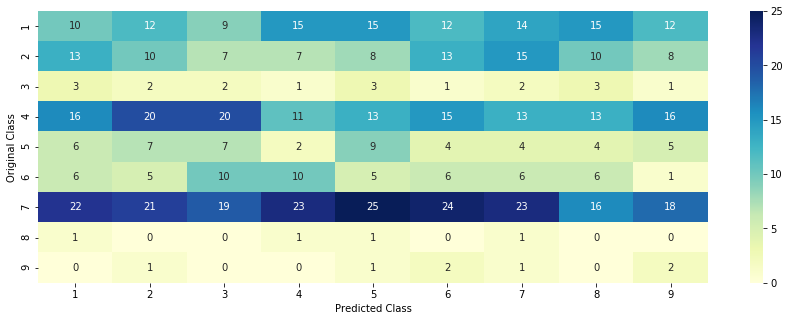

In [37]:
C = confusion_matrix(y_test, predicted_y)
labels = np.arange(1, 10)
plt.figure(figsize=(15, 5))
sns.heatmap(C, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')

### Precision matrix

Text(114.0, 0.5, 'Original Class')

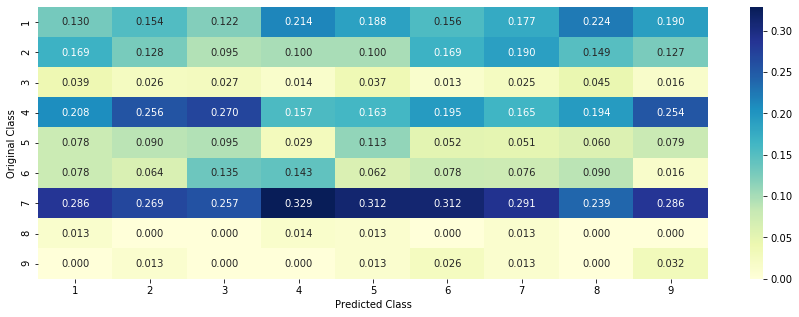

In [38]:
# vertical sum
P =(C / C.sum(axis=0))
plt.figure(figsize=(15, 5))
sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')

### Recall matrix

Text(114.0, 0.5, 'Original Class')

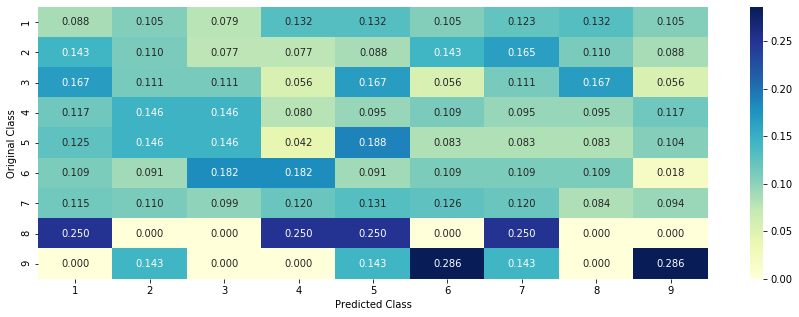

In [39]:
A = (C.T / C.sum(axis=1)).T
plt.figure(figsize=(15, 5))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')

# Building Machine Learning model

## Naive Bayes

Log Loss : 1.2701463260378905
-------------------- Confusion matrix --------------------


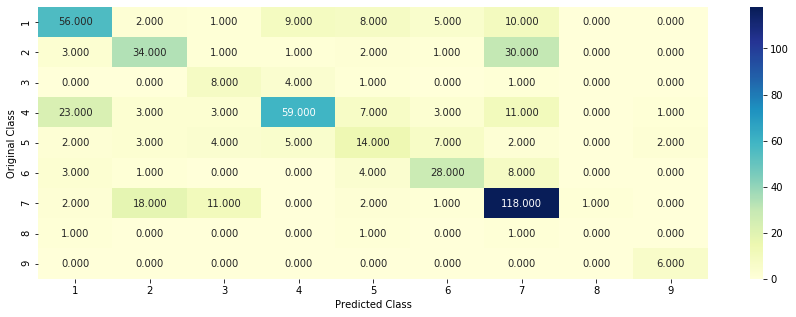

In [40]:
clf = MultinomialNB(alpha=0.0001)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

print("Log Loss :", log_loss(cv_y, sig_clf_probs))
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

## K Nearest Neighbour Classification

Log loss : 1.0164484027624798
% of Incorrect points : 0.32894736842105265
-------------------- Confusion matrix --------------------


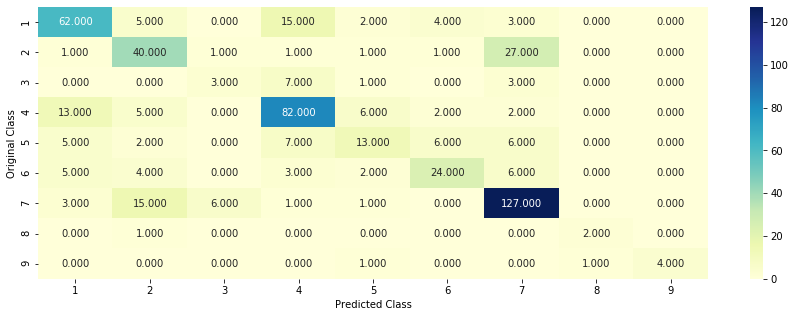

In [41]:
clf = KNeighborsClassifier(n_neighbors=10)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [42]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# to check some points
test_index = 222
pred = sig_clf.predict(test_x_responseCoding[test_index].reshape(1,-1))
print('Predicted Class:\t', pred[0])
print('Pactual Class:\t\t', test_y[test_index])

# check its neighbours
neighbors = clf.kneighbors(test_x_responseCoding[test_index].reshape(1, -1), 10)
print('\nNeighbouring Points:', neighbors[1])
print('Neighbouring Class:', train_y[neighbors[1]])
print('Neighbouring Frequency:', Counter(train_y[neighbors[1][0]]))

Predicted Class:	 2
Pactual Class:		 2

Neighbouring Points: [[1611 1590 1825 1348  474 1447  471  584 1315  312]]
Neighbouring Class: [[2 2 2 2 2 2 2 2 2 2]]
Neighbouring Frequency: Counter({2: 10})


## Logistic Regression

Log loss : 1.1072599319971643
% of Incorrect points : 0.36278195488721804
-------------------- Confusion matrix --------------------


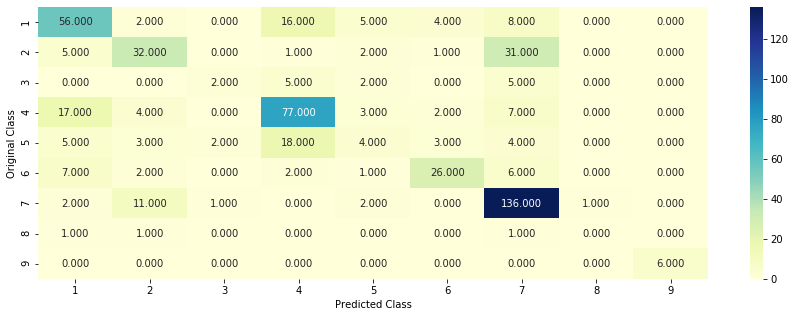

In [43]:
# with class balancing
clf = SGDClassifier(class_weight='balanced', alpha=0.0001, penalty='l2', loss='log')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [46]:
clf = SGDClassifier(class_weight='balanced', alpha=0.0001, penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, train_y)

# to check some points
test_index = 500
pred = clf.predict(test_x_onehotCoding[test_index])
print("Actual Class:\t\t", test_y[test_index])
print('Predicted Class:\t', pred[0])
print('Predicted Class Prob:', np.round(clf.predict_proba(test_x_onehotCoding[test_index]), 3))

Actual Class:		 4
Predicted Class:	 4
Predicted Class Prob: [[0.001 0.    0.021 0.977 0.    0.    0.001 0.    0.   ]]


Log loss : 1.1290983035079143
% of Incorrect points : 0.33646616541353386
-------------------- Confusion matrix --------------------


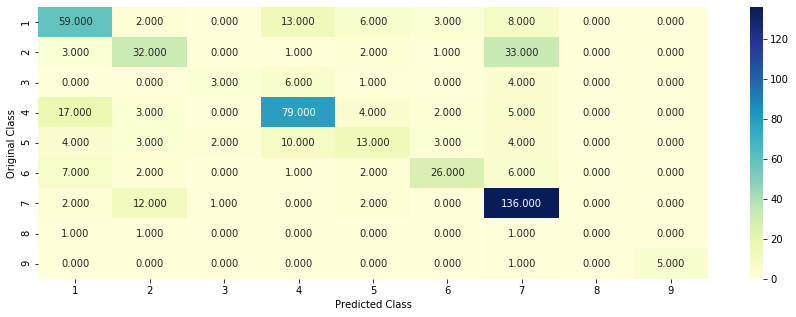

In [47]:
# without class balancing
clf = SGDClassifier(alpha=0.0001, penalty='l2', loss='log')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Random Forest Classifier

Log loss : 1.1385444163781333
% of Incorrect points : 0.34398496240601506
-------------------- Confusion matrix --------------------


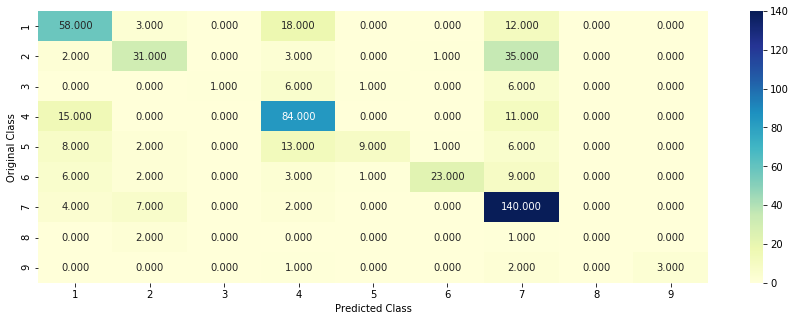

In [49]:
clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [53]:
clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_index = 100
pred = sig_clf.predict(test_x_onehotCoding[test_index])
print("Actual Class:\t\t", test_y[test_index])
print("Predicted Class:\t", pred[0])
print("Pred Class Prob:\t", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_index]), 3))

Actual Class:		 4
Predicted Class:	 4
Pred Class Prob:	 [[0.227 0.129 0.024 0.308 0.066 0.046 0.181 0.011 0.009]]


Log loss : 1.3479122612912846
% of Incorrect points : 0.5300751879699248
-------------------- Confusion matrix --------------------


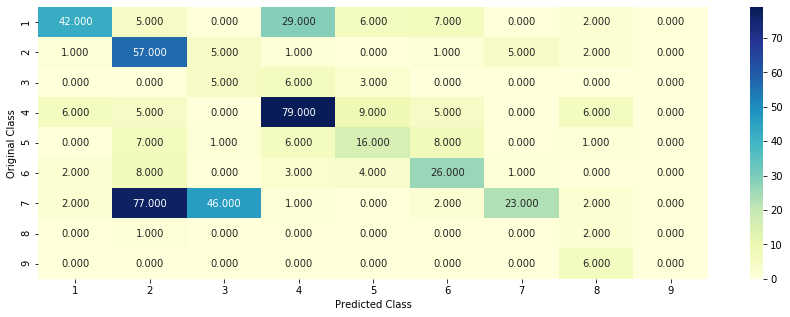

In [63]:
# rf with response encoding
clf = RandomForestClassifier(max_depth=5, n_estimators=50, criterion='gini', max_features='auto')
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

# Stacking model

0.5047938101023418
1.1482896263538331
1.2104671536660556
Log loss : 1.418974545522613
% of Incorrect points : 0.5545112781954887
-------------------- Confusion matrix --------------------


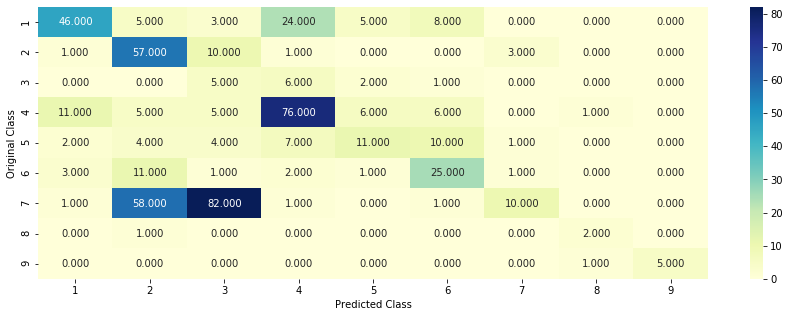

In [65]:
# # model components
# clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced')
# clf1.fit(train_x_onehotCoding, train_y)
# sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

# clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced')
# clf2.fit(train_x_onehotCoding, train_y)
# sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

# clf3 = MultinomialNB(alpha=0.001)
# clf3.fit(train_x_onehotCoding, train_y)
# sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

# sig_clf1.fit(train_x_onehotCoding, train_y)
# sig_clf2.fit(train_x_onehotCoding, train_y)
# sig_clf3.fit(train_x_onehotCoding, train_y)

# stacking
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

# evaluation
print(log_loss(train_y, sclf.predict_proba(train_x_onehotCoding)))
print(log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding)))
print(log_loss(test_y, sclf.predict_proba(test_x_onehotCoding)))
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

# Maximum voting Classifier

0.856752797439909
1.192985021745252
1.2163243121177485
Log loss : 1.291091367729
% of Incorrect points : 0.45300751879699247
-------------------- Confusion matrix --------------------


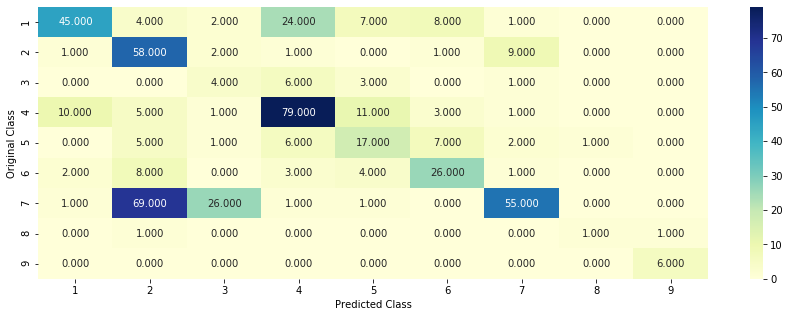

In [68]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

# evaluation
print(log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print(log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print(log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)